# **Clasificación de Imágenes con Redes Neuronales Convolucionales (CNN) en Keras**
## **Dataset: Piedra, Papel o Tijeras**

**Objetivo del Notebook:**
Este notebook presenta un flujo de trabajo completo para construir, entrenar, evaluar y utilizar modelos de Redes Neuronales Convolucionales (CNNs) para la clasificación de imágenes. Utilizaremos el dataset "Rock Paper Scissors" (Piedra, Papel o Tijeras) de TensorFlow Datasets.

**Estructura del Notebook:**
1.  Carga de las librerías necesarias.
2.  Carga del dataset (Piedra, Papel o Tijeras).
3.  Visualización del dataset y Análisis Exploratorio de Datos (EDA).
4.  Preprocesamiento del dataset (incluyendo aumento de datos).
5.  Confirmación de los Dataloaders (`tf.data.Dataset`).
6.  Definición y compilación de dos modelos CNN.
7.  Entrenamiento y evaluación de los modelos.
8.  Inferencia con el mejor modelo.
9.  Guardado del mejor modelo.

In [1]:
# 1. Carga de las Librerías
# ------------------------------------------------------------------------------

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Aunque no la usaremos para cargar, es útil conocerla

# TensorFlow Datasets para cargar el conjunto de datos
import tensorflow_datasets as tfds

# NumPy para operaciones numéricas
import numpy as np

# Matplotlib para visualización
import matplotlib.pyplot as plt

# Otras utilidades
import os # Para manejo de rutas y archivos (ej. al guardar modelos)
import datetime # Para timestamps en el guardado de modelos (opcional)

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}") # En TF 2.x, keras es parte de TF.
print(f"NumPy Version: {np.__version__}")
print(f"TFDS Version: {tfds.__version__}")

# Configuraciones opcionales para Matplotlib para mejorar la apariencia de los gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6] # Tamaño de figura por defecto
plt.rcParams['font.size'] = 12 # Tamaño de fuente por defecto

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
NumPy Version: 2.0.2
TFDS Version: 4.9.8


## **2. Carga del Dataset: Piedra, Papel o Tijeras**

En esta sección, cargaremos el dataset "Rock Paper Scissors" utilizando `tensorflow_datasets`.

Definiremos constantes globales para el tamaño de las imágenes y el tamaño del lote, y una función que se encargará de cargar, realizar un preprocesamiento básico inicial (redimensionamiento y normalización) y dividir los datos. Esta función retornará tanto los datasets listos para un entrenamiento simple como los datasets "crudos" que usaremos para el EDA y para aplicar el pipeline de aumento de datos.

In [2]:
# 2. Carga del Dataset
# ------------------------------------------------------------------------------

# Constantes Globales para el Dataset y Modelo
IMG_WIDTH = 150  # Ancho deseado para las imágenes de entrada
IMG_HEIGHT = 150 # Altura deseada para las imágenes de entrada
IMG_CHANNELS = 3 # Imágenes a color (RGB)
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

BATCH_SIZE = 32  # Tamaño del lote para el entrenamiento y evaluación
BUFFER_SIZE = 1000 # Tamaño del buffer para mezclar el dataset de entrenamiento

NOMBRE_DATASET = 'rock_paper_scissors'

def cargar_y_preparar_dataset_inicial(nombre_ds: str, img_size: tuple, batch_sz: int):
    """
    Carga un dataset de imágenes desde TensorFlow Datasets.

    Realiza una división en entrenamiento y prueba, obtiene información del dataset,
    y retorna los datasets crudos (sin preprocesamiento más allá de `as_supervised`)
    y los datasets con un preprocesamiento básico (redimensionamiento y normalización)
    listos para ser usados por un modelo.

    Args:
        nombre_ds (str): Nombre del dataset en TFDS.
        img_size (tuple): Tupla (altura, ancho) para redimensionar las imágenes.
        batch_sz (int): Tamaño del lote.

    Returns:
        tuple: Contiene:
            - train_ds_procesado (tf.data.Dataset): DS de entrenamiento preprocesado y por lotes.
            - test_ds_procesado (tf.data.Dataset): DS de prueba preprocesado y por lotes.
            - ds_train_raw (tf.data.Dataset): DS de entrenamiento crudo.
            - ds_test_raw (tf.data.Dataset): DS de prueba crudo.
            - ds_info (tfds.core.DatasetInfo): Metadatos del dataset.
            - num_clases (int): Número de clases en el dataset.
    """
    print(f"Cargando dataset '{nombre_ds}'...")
    (ds_train_raw_local, ds_test_raw_local), ds_info_local = tfds.load(
        name=nombre_ds,
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,  # Retorna (imagen, etiqueta)
        with_info=True
    )
    num_clases_local = ds_info_local.features['label'].num_classes
    print(f"Dataset cargado. Número de clases: {num_clases_local}")
    print(f"Ejemplos de entrenamiento (crudos): {ds_info_local.splits['train'].num_examples}")
    print(f"Ejemplos de prueba (crudos): {ds_info_local.splits['test'].num_examples}")

    def _preprocesar_basico(imagen, etiqueta):
        imagen = tf.image.resize(imagen, [img_size[0], img_size[1]])
        imagen = tf.cast(imagen, tf.float32) / 255.0  # Normalizar a [0,1]
        return imagen, etiqueta

    print("Creando datasets procesados básicos (redimensionados y normalizados)...")
    train_ds_proc = ds_train_raw_local.map(_preprocesar_basico, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_proc = train_ds_proc.cache().shuffle(BUFFER_SIZE).batch(batch_sz).prefetch(tf.data.AUTOTUNE)

    test_ds_proc = ds_test_raw_local.map(_preprocesar_basico, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds_proc = test_ds_proc.batch(batch_sz).cache().prefetch(tf.data.AUTOTUNE)

    print("Datasets listos.")
    return train_ds_proc, test_ds_proc, ds_train_raw_local, ds_test_raw_local, ds_info_local, num_clases_local

# Carga efectiva de los datos
(train_dataset_base, # Preprocesado básico, listo para un modelo simple
 test_dataset_base,  # Preprocesado básico, listo para un modelo simple
 ds_train_raw,       # Crudo, para EDA y pipeline de aumento
 ds_test_raw,        # Crudo, para pipeline de aumento (aunque test no se aumenta)
 dataset_info,       # Metadatos
 NUM_CLASSES) = cargar_y_preparar_dataset_inicial(NOMBRE_DATASET, IMAGE_SIZE, BATCH_SIZE)

nombres_clases = dataset_info.features['label'].names
print(f"Nombres de las clases: {nombres_clases}")

Cargando dataset 'rock_paper_scissors'...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.F6AJ4K_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.F6AJ4K_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Dataset cargado. Número de clases: 3
Ejemplos de entrenamiento (crudos): 2520
Ejemplos de prueba (crudos): 372
Creando datasets procesados básicos (redimensionados y normalizados)...
Datasets listos.
Nombres de las clases: ['rock', 'paper', 'scissors']


## **3. Visualización del Dataset y Análisis Exploratorio de Datos (EDA)**

En esta sección, exploraremos el dataset para entender mejor sus características.
1.  **Visualización Inicial:** Mostraremos algunas imágenes del dataset `train_dataset_base` (ya redimensionadas y normalizadas) para tener una primera impresión.
2.  **Distribución de Clases:** Contaremos y graficaremos el número de ejemplos por clase en el conjunto de entrenamiento crudo (`ds_train_raw`).
3.  **Dimensiones y Tipo de Datos Originales:** Revisaremos las características de las imágenes crudas.
4.  **Histogramas de Intensidad de Píxeles:** Analizaremos la distribución de colores en las imágenes crudas.
5.  **Visualización Detallada por Clase (Imágenes Crudas):** Mostraremos ejemplos de `ds_train_raw` para cada clase.



--- 3.1 Visualización Inicial (Imágenes Preprocesadas Base) ---


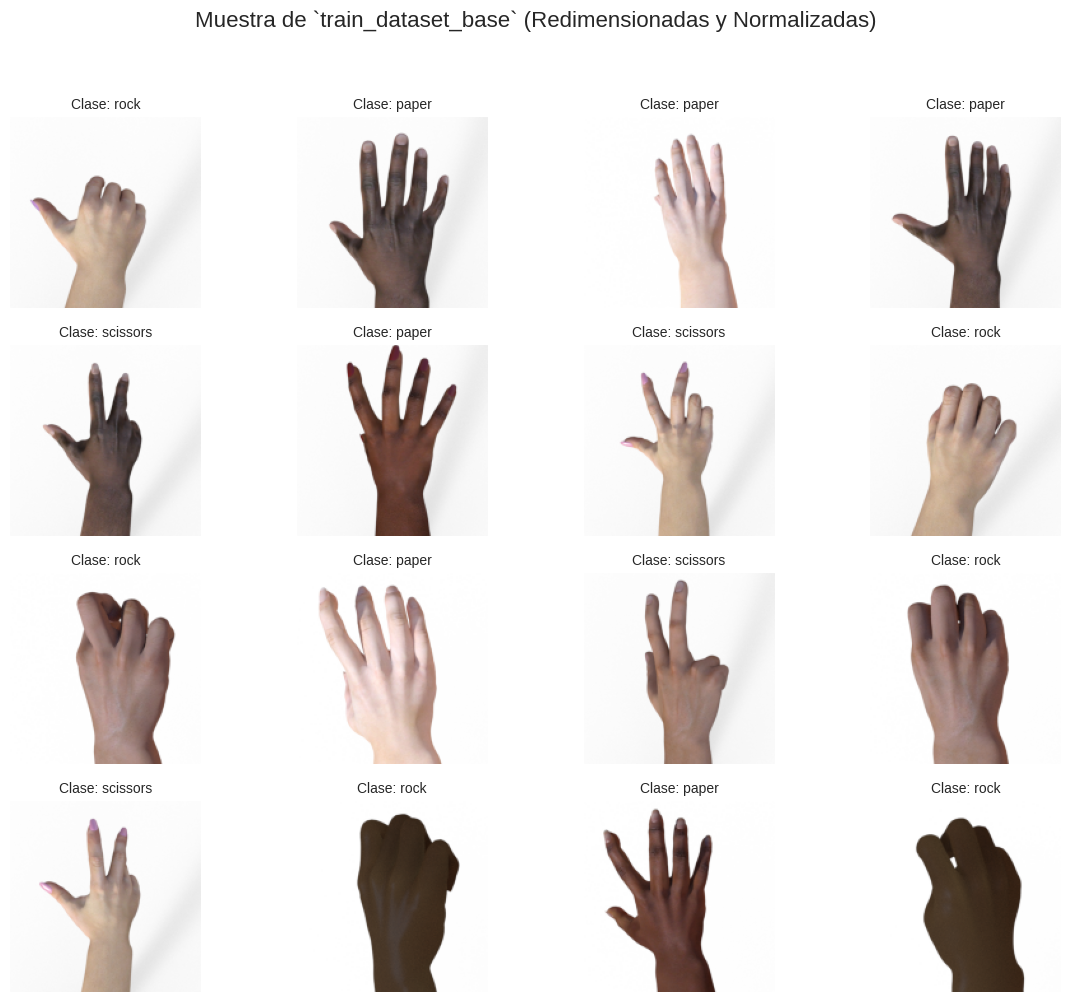


--- 3.2 Distribución de Clases (Dataset Crudo) ---
Contando ejemplos por clase en `ds_train_raw`...
Conteo por clase (entrenamiento crudo): {'rock': 840, 'paper': 840, 'scissors': 840}
Total ejemplos contados: 2520 (Esperado: 2520)


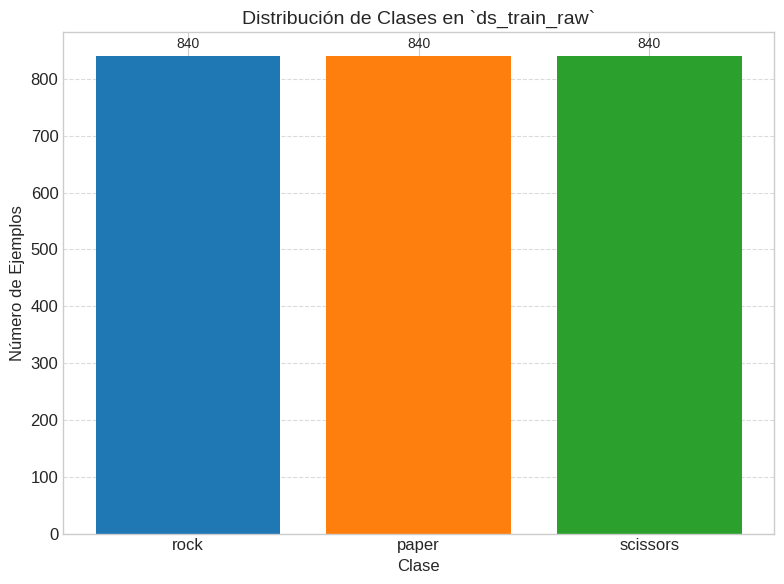


--- 3.3 Dimensiones y Tipo de Datos Originales ---
Forma original de las imágenes (alto, ancho, canales): (300, 300, 3)
Tipo de datos original de las imágenes: <dtype: 'uint8'>

--- 3.4 Histogramas de Intensidad de Píxeles (Dataset Crudo) ---
Mostrando histogramas para 1 ejemplo por clase de `ds_train_raw`:

Histograma para Clase: paper


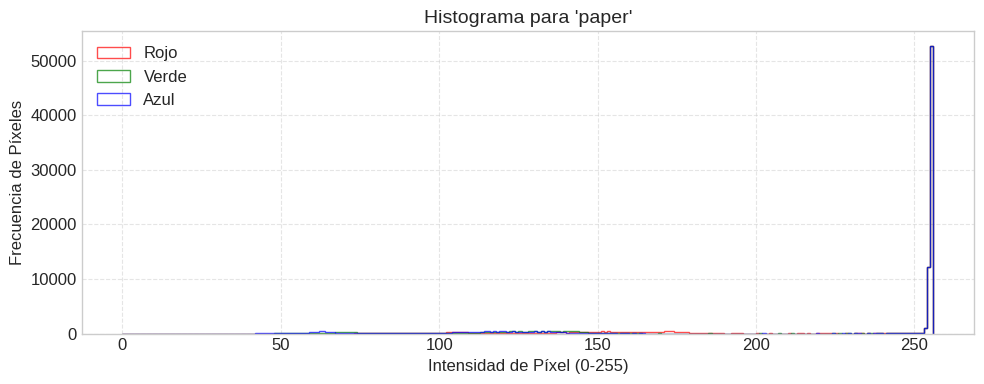


Histograma para Clase: scissors


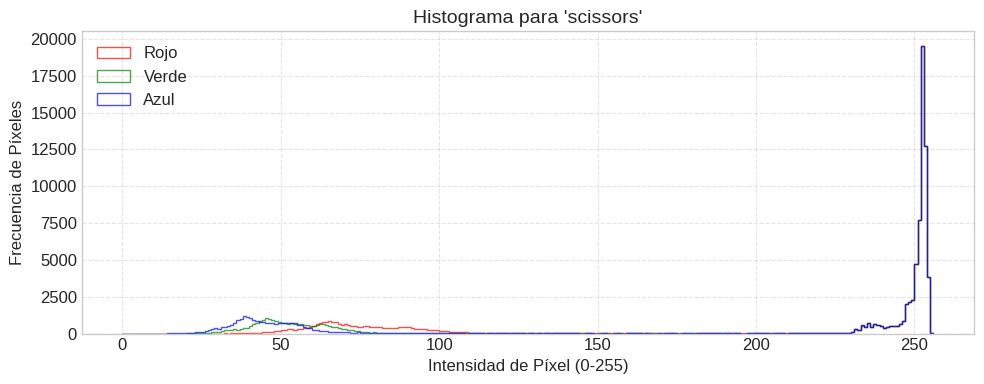


Histograma para Clase: rock


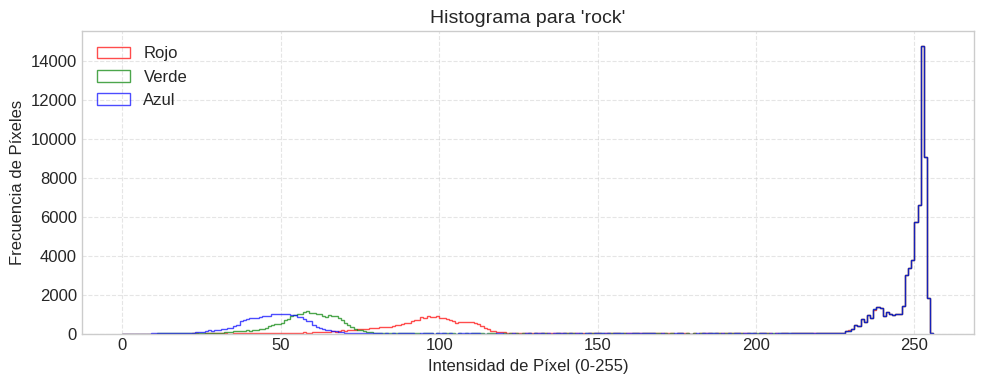


--- 3.5 Visualización Detallada por Clase (Imágenes Crudas de `ds_train_raw`) ---


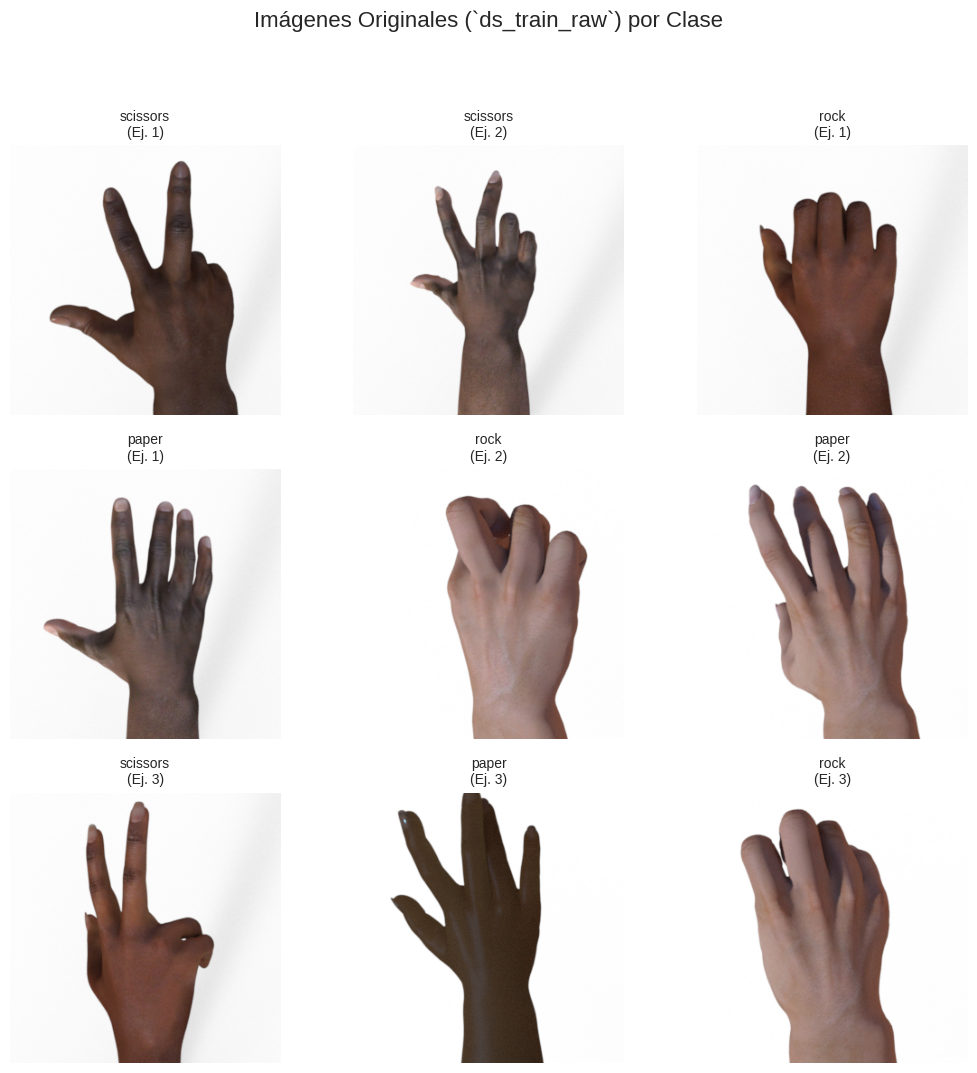

In [3]:
# 3. Visualización del Dataset y EDA
# ------------------------------------------------------------------------------

# 3.1 Visualización Inicial (del dataset preprocesado base)
# ------------------------------------------------------------------------------
print("\n--- 3.1 Visualización Inicial (Imágenes Preprocesadas Base) ---")
def mostrar_lote_imagenes(dataset, titulo_figura="Muestra de Imágenes del Dataset"):
    """Muestra un lote de imágenes de un dataset dado."""
    plt.figure(figsize=(12, 10))
    plt.suptitle(titulo_figura, fontsize=16, y=1.0)
    for images, labels in dataset.take(1): # Tomar un solo lote
        for i in range(min(16, images.shape[0])): # Mostrar hasta 16 imágenes
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy()) # Las imágenes ya están en [0,1]
            plt.title(f"Clase: {nombres_clases[labels[i].numpy()]}", fontsize=10)
            plt.axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

mostrar_lote_imagenes(train_dataset_base, "Muestra de `train_dataset_base` (Redimensionadas y Normalizadas)")

# 3.2 Distribución de Clases (del dataset crudo)
# ------------------------------------------------------------------------------
print("\n--- 3.2 Distribución de Clases (Dataset Crudo) ---")
counts_train_clases = [0] * NUM_CLASSES
print("Contando ejemplos por clase en `ds_train_raw`...")
for _, label_tensor in ds_train_raw:
    counts_train_clases[label_tensor.numpy()] += 1

total_ejemplos_contados_eda = sum(counts_train_clases)
print(f"Conteo por clase (entrenamiento crudo): {dict(zip(nombres_clases, counts_train_clases))}")
print(f"Total ejemplos contados: {total_ejemplos_contados_eda} (Esperado: {dataset_info.splits['train'].num_examples})")

plt.figure(figsize=(8, 6))
bars = plt.bar(nombres_clases, counts_train_clases, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Distribución de Clases en `ds_train_raw`', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Número de Ejemplos', fontsize=12)
for i, count_val in enumerate(counts_train_clases):
    plt.text(i, count_val + (max(counts_train_clases) * 0.01), str(count_val), ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.3 Dimensiones y Tipo de Datos Originales
# ------------------------------------------------------------------------------
print("\n--- 3.3 Dimensiones y Tipo de Datos Originales ---")
print(f"Forma original de las imágenes (alto, ancho, canales): {dataset_info.features['image'].shape}")
print(f"Tipo de datos original de las imágenes: {dataset_info.features['image'].dtype}")

# 3.4 Histogramas de Intensidad de Píxeles (del dataset crudo)
# ------------------------------------------------------------------------------
print("\n--- 3.4 Histogramas de Intensidad de Píxeles (Dataset Crudo) ---")
def plot_histograma_pixel(imagen_tensor, titulo_hist="Histograma de Intensidad de Píxeles"):
    imagen_np = imagen_tensor.numpy().astype("uint8") # Asegurar uint8 para histograma 0-255
    plt.figure(figsize=(10, 4))
    colores_canal = ('red', 'green', 'blue')
    nombres_canal = ('Rojo', 'Verde', 'Azul')
    for i, color_c in enumerate(colores_canal):
        canal_pixeles = imagen_np[:, :, i].ravel()
        plt.hist(canal_pixeles, bins=256, range=[0,256], color=color_c, label=nombres_canal[i], alpha=0.7, histtype='step')
    plt.title(titulo_hist, fontsize=14)
    plt.xlabel("Intensidad de Píxel (0-255)", fontsize=12)
    plt.ylabel("Frecuencia de Píxeles", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

print("Mostrando histogramas para 1 ejemplo por clase de `ds_train_raw`:")
muestras_hist_mostradas = [0] * NUM_CLASSES
for img_raw, lbl_raw in ds_train_raw:
    clase_idx_raw = lbl_raw.numpy()
    if muestras_hist_mostradas[clase_idx_raw] < 1:
        print(f"\nHistograma para Clase: {nombres_clases[clase_idx_raw]}")
        plot_histograma_pixel(img_raw, f"Histograma para '{nombres_clases[clase_idx_raw]}'")
        muestras_hist_mostradas[clase_idx_raw] += 1
    if all(c >= 1 for c in muestras_hist_mostradas):
        break

# 3.5 Visualización Detallada por Clase (Imágenes Crudas)
# ------------------------------------------------------------------------------
print("\n--- 3.5 Visualización Detallada por Clase (Imágenes Crudas de `ds_train_raw`) ---")
num_ejemplos_clase_viz_raw = 3
plt.figure(figsize=(num_ejemplos_clase_viz_raw * 3.5, NUM_CLASSES * 3.5))
plt.suptitle("Imágenes Originales (`ds_train_raw`) por Clase", fontsize=16, y=1.02)
muestras_clase_mostradas_raw = [0] * NUM_CLASSES
idx_plot_raw = 1
for img_r, lbl_r in ds_train_raw:
    clase_idx_r = lbl_r.numpy()
    if muestras_clase_mostradas_raw[clase_idx_r] < num_ejemplos_clase_viz_raw:
        plt.subplot(NUM_CLASSES, num_ejemplos_clase_viz_raw, idx_plot_raw)
        plt.imshow(img_r.numpy().astype("uint8"))
        plt.title(f"{nombres_clases[clase_idx_r]}\n(Ej. {muestras_clase_mostradas_raw[clase_idx_r]+1})", fontsize=10)
        plt.axis('off')
        muestras_clase_mostradas_raw[clase_idx_r] += 1
        idx_plot_raw += 1
    if all(c >= num_ejemplos_clase_viz_raw for c in muestras_clase_mostradas_raw):
        break
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()

## **4. Preprocesamiento del Dataset (Aumento de Datos)**

Ahora que hemos explorado los datos, procederemos con un preprocesamiento más avanzado, específicamente el **Aumento de Datos** (*Data Augmentation*).

1.  **Función de Preprocesamiento Base:** Definiremos una función que redimensiona y normaliza las imágenes. Esta se usará tanto para el conjunto de entrenamiento (antes del aumento) como para el de prueba.
2.  **Pipeline de Aumento de Datos:** Crearemos un pipeline con capas de Keras para aplicar transformaciones aleatorias (volteos, rotaciones, zoom, etc.) a las imágenes de entrenamiento.
3.  **Aplicación a los Datasets:**
     * `train_dataset_augmented`: Se creará aplicando el preprocesamiento base y luego el aumento de datos a `ds_train_raw`.
     * `test_dataset_final`: Se creará aplicando solo el preprocesamiento base a `ds_test_raw`.
4.  **Visualización:** Mostraremos ejemplos de imágenes aumentadas.

Los datasets resultantes (`train_dataset_augmented` y `test_dataset_final`) serán los que alimentarán a nuestros modelos.


Creando `train_dataset_augmented`...
`train_dataset_augmented` listo: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Creando `test_dataset_final`...
`test_dataset_final` listo: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

--- 4.4 Visualización del Aumento de Datos ---
Mostrando ejemplos de `train_dataset_augmented`:


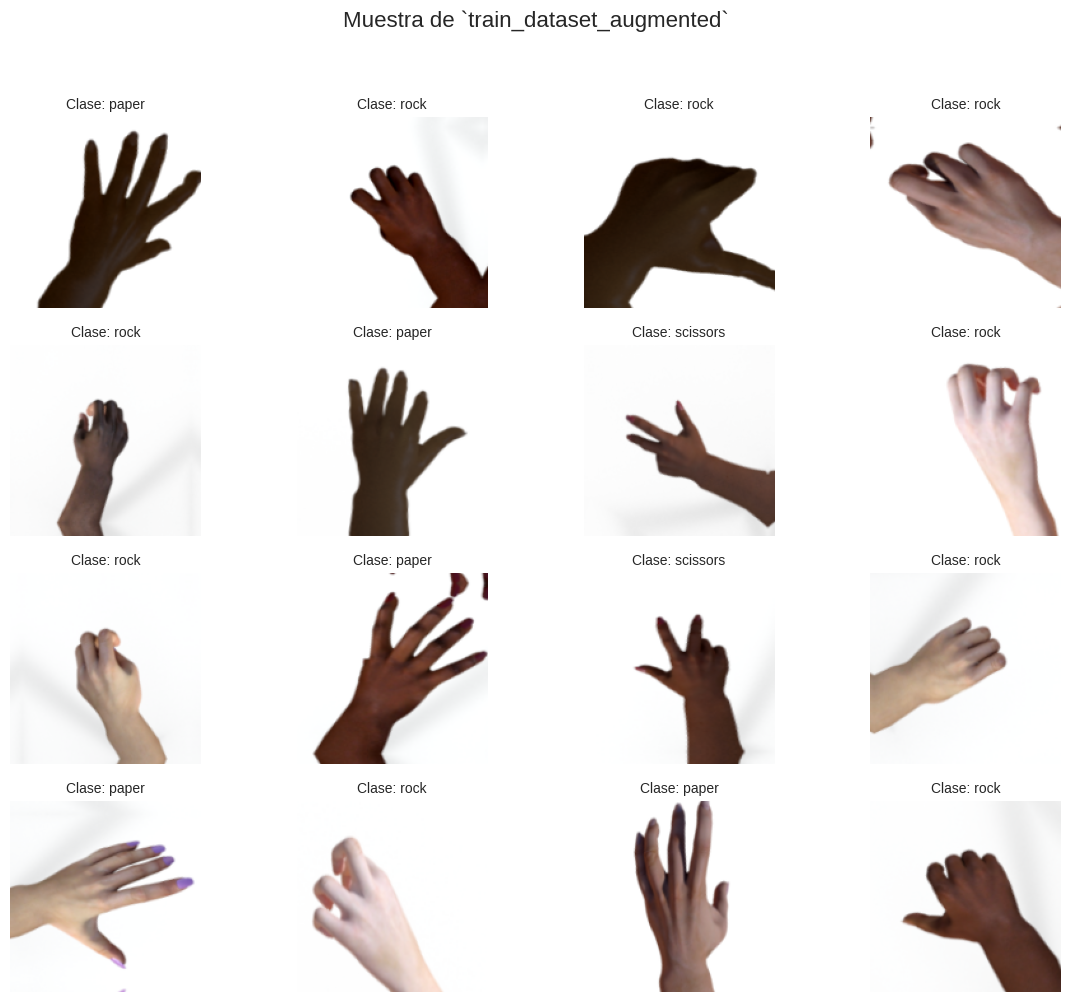


Comparando imagen original (preprocesada) con versiones aumentadas:


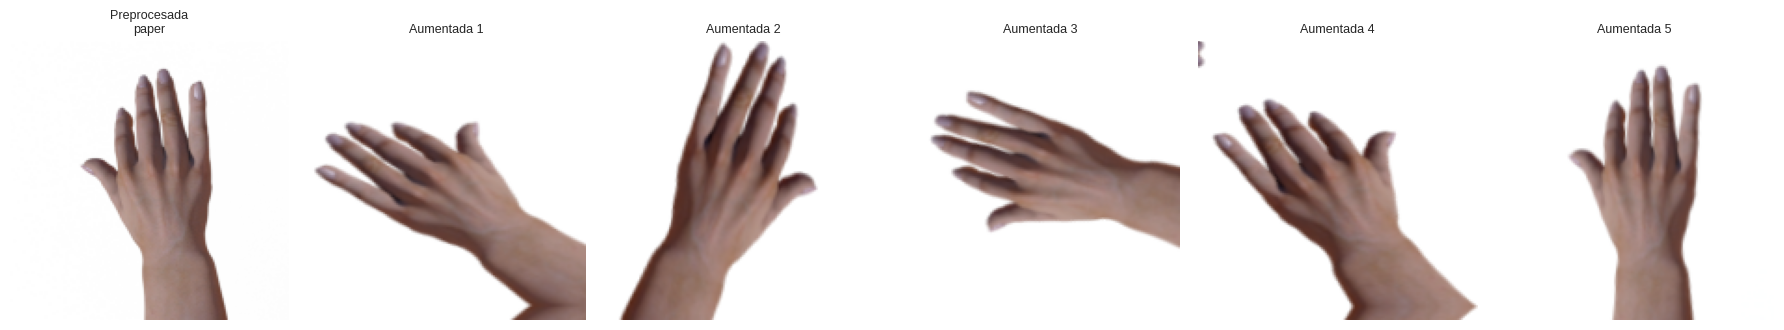

In [4]:
# 4. Preprocesamiento del Dataset (Aumento de Datos)
# ------------------------------------------------------------------------------

# 4.1 Función de Preprocesamiento Base (Redimensionar y Normalizar)
# ------------------------------------------------------------------------------
def preprocesar_para_modelo(imagen, etiqueta):
    """Redimensiona y normaliza una imagen. Castea a float32."""
    imagen = tf.image.resize(imagen, IMAGE_SIZE)
    imagen = tf.cast(imagen, tf.float32) / 255.0
    return imagen, etiqueta

# 4.2 Pipeline de Aumento de Datos
# ------------------------------------------------------------------------------
data_augmentation_pipeline = Sequential([
    Input(shape=INPUT_SHAPE), # Capa Input explícita para claridad y posible `summary()`
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2)
], name="data_augmentation")

# 4.3 Aplicación a los Datasets
# ------------------------------------------------------------------------------
print("Creando `train_dataset_augmented`...")
train_dataset_augmented = ds_train_raw.map(preprocesar_para_modelo, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_augmented = train_dataset_augmented.map(
    lambda img, lbl: (data_augmentation_pipeline(tf.expand_dims(img, axis=0), training=True)[0], lbl), num_parallel_calls=tf.data.AUTOTUNE)


train_dataset_augmented = train_dataset_augmented.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(f"`train_dataset_augmented` listo: {train_dataset_augmented}")

print("\nCreando `test_dataset_final`...")
test_dataset_final = ds_test_raw.map(preprocesar_para_modelo, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset_final = test_dataset_final.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
print(f"`test_dataset_final` listo: {test_dataset_final}")

# 4.4 Visualización del Aumento
# ------------------------------------------------------------------------------
print("\n--- 4.4 Visualización del Aumento de Datos ---")
print("Mostrando ejemplos de `train_dataset_augmented`:")
mostrar_lote_imagenes(train_dataset_augmented, "Muestra de `train_dataset_augmented`")

print("\nComparando imagen original (preprocesada) con versiones aumentadas:")
for img_orig_raw, lbl_orig_raw in ds_train_raw.take(1): # Tomar una imagen cruda
    img_proc_single, _ = preprocesar_para_modelo(img_orig_raw, lbl_orig_raw) # Preprocesar base

    plt.figure(figsize=(18, 4))
    plt.subplot(1, 6, 1) # Ajustar para 1 original + 5 aumentadas
    plt.imshow(img_proc_single.numpy())
    plt.title(f"Preprocesada\n{nombres_clases[lbl_orig_raw.numpy()]}", fontsize=9)
    plt.axis('off')

    for i in range(5): # Generar 5 versiones aumentadas
        augmented_img_batch = data_augmentation_pipeline(tf.expand_dims(img_proc_single, axis=0), training=True)
        plt.subplot(1, 6, i + 2)
        plt.imshow(augmented_img_batch[0].numpy())
        plt.title(f"Aumentada {i+1}", fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

## **5. Confirmación de los Dataloaders (`tf.data.Dataset`)**

Los pasos anteriores han generado los datasets que se utilizarán para el entrenamiento y la evaluación de nuestros modelos:

* **`train_dataset_augmented`**: Contiene las imágenes de entrenamiento que han sido redimensionadas, normalizadas y sometidas a aumento de datos. Está configurado con `.cache()`, `.shuffle()`, `.batch()` y `.prefetch()` para un rendimiento óptimo durante el entrenamiento.
* **`test_dataset_final`**: Contiene las imágenes de prueba que han sido redimensionadas y normalizadas (sin aumento de datos). Está configurado con `.batch()`, `.cache()` y `.prefetch()` para una evaluación eficiente.

Estos objetos `tf.data.Dataset` actúan como *dataloaders* eficientes, listos para ser pasados directamente a los métodos `fit()` y `evaluate()` de los modelos Keras.


## **6. Definición y Compilación de Modelos CNN**

Definiremos dos arquitecturas de Redes Neuronales Convolucionales (CNNs) utilizando la API Secuencial de Keras.

* **Modelo 1: CNN Sencilla**
     * Una arquitectura más simple con menos capas convolucionales y de pooling.
* **Modelo 2: CNN Mejorada**
     * Una arquitectura más profunda, incorporando capas como `BatchNormalization` y `Dropout` para mejorar el rendimiento y reducir el sobreajuste.

Ambos modelos serán compilados con el optimizador Adam, la función de pérdida `sparse_categorical_crossentropy` (ya que nuestras etiquetas son enteros) y la métrica de `accuracy`.

In [5]:
# 6. Definición y Compilación de Modelos CNN
# ------------------------------------------------------------------------------

def crear_modelo_cnn_sencillo(input_s, num_cl, nombre_modelo="CNN_Sencilla"):
    """Crea un modelo CNN sencillo."""
    model = Sequential([
        Input(shape=input_s, name="input_layer"),
        Conv2D(32, (3, 3), activation='relu', name="conv1"),
        MaxPooling2D((2, 2), name="pool1"),
        Conv2D(64, (3, 3), activation='relu', name="conv2"),
        MaxPooling2D((2, 2), name="pool2"),
        Flatten(name="flatten"),
        Dense(64, activation='relu', name="dense1"),
        Dense(num_cl, activation='softmax', name="output_layer") # Softmax para clasificación multiclase
    ], name=nombre_modelo)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def crear_modelo_cnn_mejorado(input_s, num_cl, nombre_modelo="CNN_Mejorada"):
    """Crea un modelo CNN más robusto con BatchNormalization y Dropout."""
    model = Sequential([
        Input(shape=input_s, name="input_layer"),

        Conv2D(32, (3, 3), padding='same', name="conv1_1"),
        BatchNormalization(name="bn1_1"),
        tf.keras.layers.Activation('relu', name="act1_1"),
        MaxPooling2D((2, 2), name="pool1"),

        Conv2D(64, (3, 3), padding='same', name="conv2_1"),
        BatchNormalization(name="bn2_1"),
        tf.keras.layers.Activation('relu', name="act2_1"),
        Conv2D(64, (3, 3), padding='same', name="conv2_2"), # Capa adicional
        BatchNormalization(name="bn2_2"),
        tf.keras.layers.Activation('relu', name="act2_2"),
        MaxPooling2D((2, 2), name="pool2"),

        Conv2D(128, (3, 3), padding='same', name="conv3_1"),
        BatchNormalization(name="bn3_1"),
        tf.keras.layers.Activation('relu', name="act3_1"),
        MaxPooling2D((2, 2), name="pool3"),

        Flatten(name="flatten"),
        Dense(128, name="dense1"),
        BatchNormalization(name="bn_dense1"),
        tf.keras.layers.Activation('relu', name="act_dense1"),
        Dropout(0.5, name="dropout1"), # Dropout para regularización

        Dense(num_cl, activation='softmax', name="output_layer")
    ], name=nombre_modelo)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Crear instancias de los modelos
modelo_cnn_1 = crear_modelo_cnn_sencillo(INPUT_SHAPE, NUM_CLASSES)
modelo_cnn_2 = crear_modelo_cnn_mejorado(INPUT_SHAPE, NUM_CLASSES)

print("--- Modelo CNN Sencillo ---")
modelo_cnn_1.summary()
print("\n--- Modelo CNN Mejorado ---")
modelo_cnn_2.summary()

print("\nModelos CNN definidos y compilados.")

--- Modelo CNN Sencillo ---


Model: "CNN_Sencilla"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,328,067 (20.32 MB)

 Trainable params: 5,328,067 (20.32 MB)

 Non-trainable params: 0 (0.00 B)


--- Modelo CNN Mejorado ---


Model: "CNN_Mejorada"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act1_1 (Activation)             │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 75, 75, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act2_1 (Activation)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 75, 75, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act2_2 (Activation)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 37, 37, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act3_1 (Activation)             │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_dense1 (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,440,771 (20.75 MB)

 Trainable params: 5,439,939 (20.75 MB)

 Non-trainable params: 832 (3.25 KB)


Modelos CNN definidos y compilados.


## **7. Entrenamiento y Evaluación de los Modelos**

En esta sección, entrenaremos ambos modelos CNN utilizando `train_dataset_augmented` y los evaluaremos con `test_dataset_final`.

1.  **Callbacks:** Definiremos callbacks como `EarlyStopping` para detener el entrenamiento si no hay mejora y `ModelCheckpoint` para guardar el mejor modelo durante el entrenamiento (opcional aquí, ya que guardaremos al final).
2.  **Función de Entrenamiento y Evaluación:** Crearemos una función para encapsular el proceso de entrenamiento, graficar el historial y evaluar el modelo.
3.  **Ejecución:** Entrenaremos y evaluaremos cada modelo.


--- Entrenando CNN Sencilla ---
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.4192 - loss: 1.3786 - val_accuracy: 0.8118 - val_loss: 0.5223
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8599 - loss: 0.3902 - val_accuracy: 0.7742 - val_loss: 0.5749
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9443 - loss: 0.1703 - val_accuracy: 0.8253 - val_loss: 0.4609
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9646 - loss: 0.1195 - val_accuracy: 0.8575 - val_loss: 0.2882
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9746 - loss: 0.0767 - val_accuracy: 0.8226 - val_loss: 0.4077
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9920 - loss: 0.0364 - val_accuracy: 0.7151 - val_loss: 1.0603
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9674 - loss: 0.1075 - val_accuracy: 0.8226 - val_loss: 0.3824
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9917 - loss

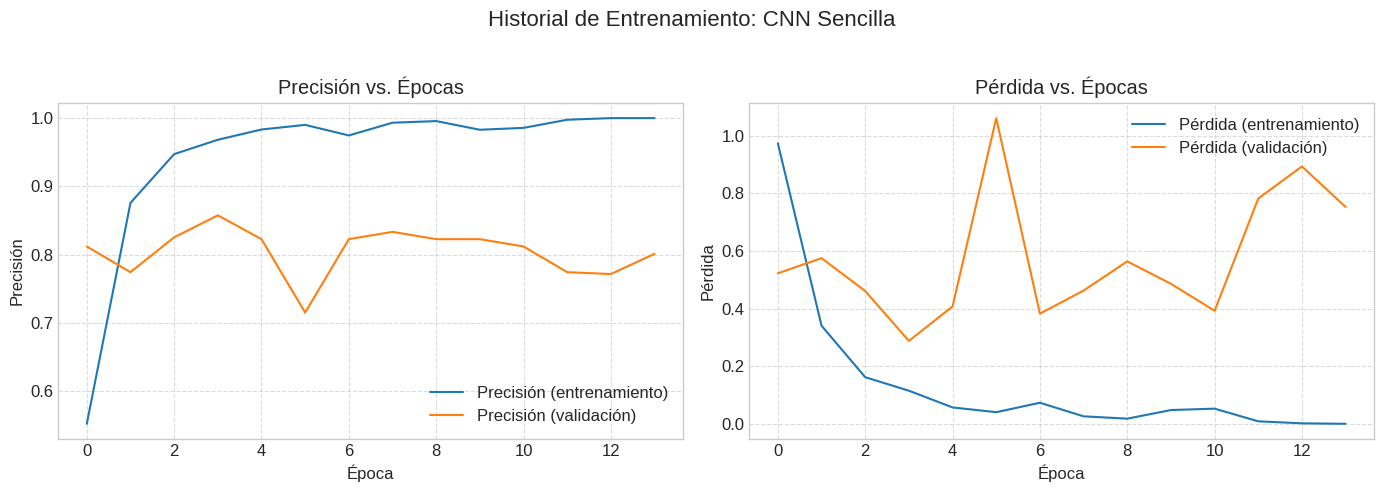


--- Evaluando CNN Sencilla en el conjunto de prueba ---
Pérdida en prueba (CNN Sencilla): 0.2882
Precisión en prueba (CNN Sencilla): 0.8575 (85.75%)

--- Entrenando CNN Mejorada ---
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.6588 - loss: 0.9609 - val_accuracy: 0.3333 - val_loss: 5.5321
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9415 - loss: 0.1650 - val_accuracy: 0.3333 - val_loss: 5.3243
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9733 - loss: 0.0951 - val_accuracy: 0.6559 - val_loss: 4.7398
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9695 - loss: 0.0850 - val_accuracy: 0.6263 - val_loss: 4.2383
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9892 - loss: 0.0440 - val_accuracy: 0.4946 - val_loss: 1.5361
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9893 - loss: 0.0477 - val_accuracy: 0.6263 - val_loss: 4.7248
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - 

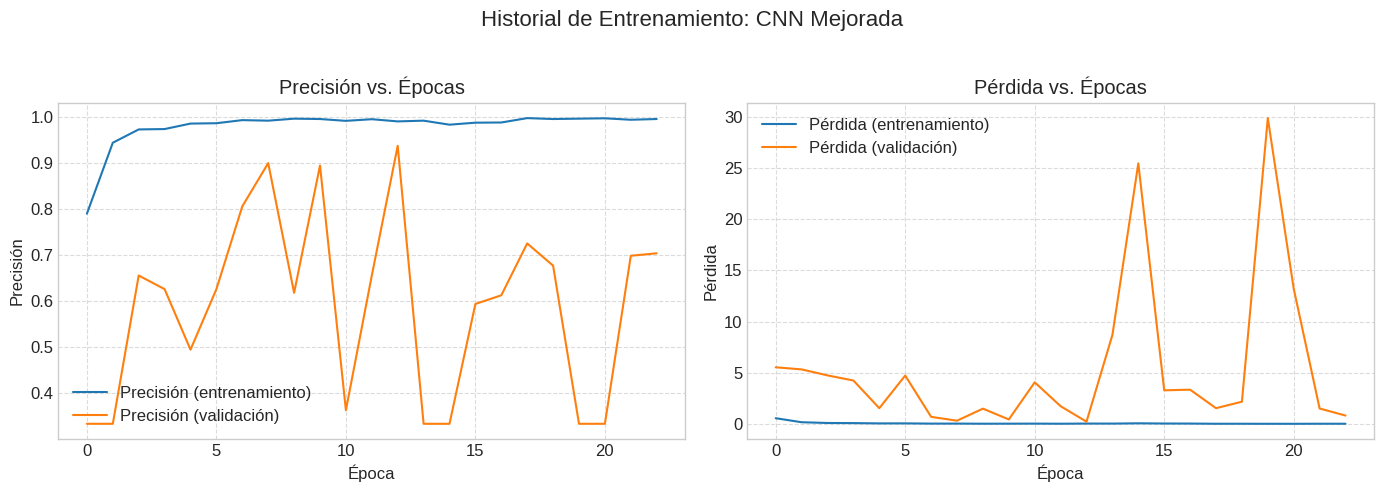


--- Evaluando CNN Mejorada en el conjunto de prueba ---
Pérdida en prueba (CNN Mejorada): 0.2148
Precisión en prueba (CNN Mejorada): 0.9382 (93.82%)

--- Resumen de Resultados ---
CNN Sencilla: Precisión en Prueba = 85.75%, Pérdida = 0.2882
CNN Mejorada: Precisión en Prueba = 93.82%, Pérdida = 0.2148

El mejor modelo es: CNN Mejorada con precisión 93.82%


In [6]:
# 7. Entrenamiento y Evaluación de los Modelos
# ------------------------------------------------------------------------------

# 7.1 Callbacks
# ------------------------------------------------------------------------------
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Para ModelCheckpoint, necesitaríamos definir una ruta de archivo. Lo omitimos por ahora y guardaremos manualmente al final.

# 7.2 Función para entrenar, graficar y evaluar
# ------------------------------------------------------------------------------
def entrenar_evaluar_modelo(modelo, train_ds, val_ds, epochs=50, callbacks_list=None, nombre_modelo_graf="Modelo"):
    """Entrena un modelo, grafica su historial y lo evalúa."""
    if callbacks_list is None:
        callbacks_list = [early_stopping_cb]

    print(f"\n--- Entrenando {nombre_modelo_graf} ---")
    history = modelo.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=callbacks_list,
        verbose=1 # Muestra barra de progreso por época
    )

    # Graficar historial
    plt.figure(figsize=(14, 5))
    plt.suptitle(f"Historial de Entrenamiento: {nombre_modelo_graf}", fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Precisión (entrenamiento)')
    plt.plot(history.history['val_accuracy'], label='Precisión (validación)')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión vs. Épocas')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
    plt.plot(history.history['val_loss'], label='Pérdida (validación)')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida vs. Épocas')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

    print(f"\n--- Evaluando {nombre_modelo_graf} en el conjunto de prueba ---")
    loss, accuracy = modelo.evaluate(val_ds, verbose=0)
    print(f"Pérdida en prueba ({nombre_modelo_graf}): {loss:.4f}")
    print(f"Precisión en prueba ({nombre_modelo_graf}): {accuracy:.4f} ({accuracy*100:.2f}%)")

    return history, accuracy, loss

# 7.3 Ejecución para cada modelo
# ------------------------------------------------------------------------------
EPOCHS = 30 # Reducir para ejecución más rápida en un ejemplo, aumentar para mejor rendimiento potencial

# Entrenar y evaluar Modelo 1: CNN Sencilla
historia_modelo_1, acc_modelo_1, loss_modelo_1 = entrenar_evaluar_modelo(
    modelo_cnn_1,
    train_dataset_augmented,
    test_dataset_final,
    epochs=EPOCHS,
    nombre_modelo_graf="CNN Sencilla"
)

# Entrenar y evaluar Modelo 2: CNN Mejorada
historia_modelo_2, acc_modelo_2, loss_modelo_2 = entrenar_evaluar_modelo(
    modelo_cnn_2,
    train_dataset_augmented,
    test_dataset_final,
    epochs=EPOCHS, # Podríamos usar más épocas para el modelo mejorado
    nombre_modelo_graf="CNN Mejorada"
)

print("\n--- Resumen de Resultados ---")
print(f"CNN Sencilla: Precisión en Prueba = {acc_modelo_1*100:.2f}%, Pérdida = {loss_modelo_1:.4f}")
print(f"CNN Mejorada: Precisión en Prueba = {acc_modelo_2*100:.2f}%, Pérdida = {loss_modelo_2:.4f}")

# Seleccionar el mejor modelo basado en la precisión en prueba
mejor_modelo = modelo_cnn_1 if acc_modelo_1 > acc_modelo_2 else modelo_cnn_2
nombre_mejor_modelo = "CNN Sencilla" if acc_modelo_1 > acc_modelo_2 else "CNN Mejorada"
print(f"\nEl mejor modelo es: {nombre_mejor_modelo} con precisión {max(acc_modelo_1, acc_modelo_2)*100:.2f}%")


## **8. Inferencia con el Mejor Modelo**

Una vez entrenado y evaluado nuestro modelo, el siguiente paso es utilizarlo para hacer predicciones sobre nuevas imágenes (inferencia). Tomaremos algunas imágenes del conjunto de prueba (`ds_test_raw`), las preprocesaremos de la misma manera que se hizo para la evaluación (sin aumento de datos), y luego usaremos el mejor modelo entrenado para predecir su clase. Visualizaremos las imágenes junto con sus etiquetas verdaderas y las predicciones del modelo.


Inferencia Usando el modelo: CNN Mejorada


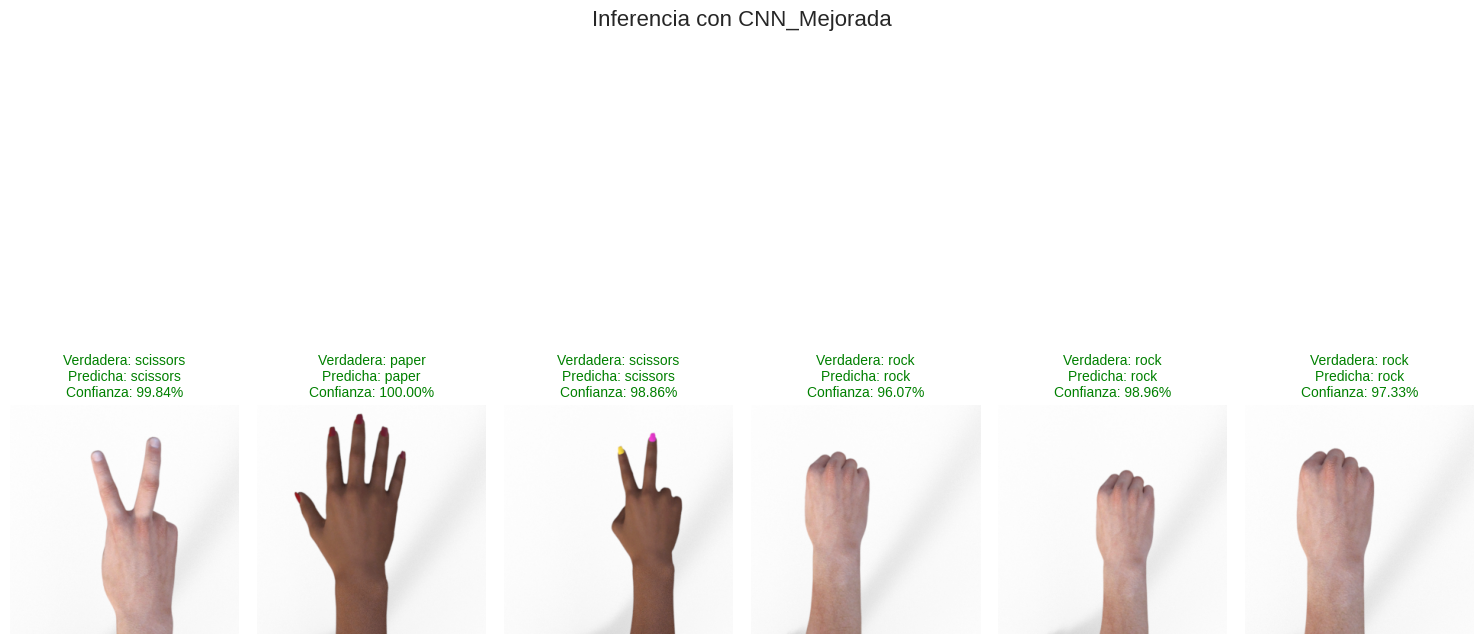

In [7]:
### 8. Inferencia con el Mejor Modelo
# ------------------------------------------------------------------------------
print(f"Inferencia Usando el modelo: {nombre_mejor_modelo}")

def realizar_inferencia_y_mostrar(modelo, dataset_crudo_infer, num_imgs_infer=5):
    """Realiza inferencia en unas pocas imágenes y las muestra con sus predicciones."""
    plt.figure(figsize=(15, num_imgs_infer * 1.5)) # Ajustar tamaño según número de imágenes
    plt.suptitle(f"Inferencia con {modelo.name}", fontsize=16, y=1.02)

    idx_plot_infer = 1
    for img_inf_raw, lbl_inf_raw in dataset_crudo_infer.take(num_imgs_infer):
        # Preprocesar la imagen cruda para el modelo
        img_inf_proc, _ = preprocesar_para_modelo(img_inf_raw, lbl_inf_raw) # Usamos la función de preproc base

        # Añadir dimensión de lote (batch) para la predicción
        img_inf_batch = tf.expand_dims(img_inf_proc, axis=0)

        # Realizar la predicción
        prediccion_probs = modelo.predict(img_inf_batch, verbose=0)[0] # [0] para obtener el array de probs del primer (y único) elemento del lote
        clase_predicha_idx = np.argmax(prediccion_probs)
        confianza_prediccion = np.max(prediccion_probs)

        etiqueta_verdadera_str = nombres_clases[lbl_inf_raw.numpy()]
        etiqueta_predicha_str = nombres_clases[clase_predicha_idx]

        # Mostrar la imagen original (cruda) para una mejor visualización humana
        plt.subplot(1, num_imgs_infer, idx_plot_infer) # Layout horizontal
        plt.imshow(img_inf_raw.numpy().astype("uint8")) # Imagen cruda
        titulo_infer = (f"Verdadera: {etiqueta_verdadera_str}\n"
                        f"Predicha: {etiqueta_predicha_str}\n"
                        f"Confianza: {confianza_prediccion:.2%}")
        color_titulo = 'green' if etiqueta_verdadera_str == etiqueta_predicha_str else 'red'
        plt.title(titulo_infer, fontsize=10, color=color_titulo)
        plt.axis('off')
        idx_plot_infer += 1

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Realizar inferencia con el mejor modelo en algunas imágenes de `ds_test_raw`
realizar_inferencia_y_mostrar(mejor_modelo, ds_test_raw, num_imgs_infer=NUM_CLASSES * 2) # Mostrar 2 ejemplos por clase


## **9. Guardar el Mejor Modelo**

Finalmente, es una buena práctica guardar el modelo entrenado para poder reutilizarlo en el futuro sin necesidad de reentrenar.
Keras proporciona una forma sencilla de guardar tanto la arquitectura del modelo como sus pesos aprendidos, e incluso el estado del optimizador.
Utilizaremos el formato `.keras` que es el recomendado actualmente.

In [8]:
# 9. Guardar el Mejor Modelo
# ------------------------------------------------------------------------------

# Crear un directorio para guardar los modelos si no existe
modelos_guardados_dir = "modelos_cnn_guardados"
if not os.path.exists(modelos_guardados_dir):
    os.makedirs(modelos_guardados_dir)

# Definir el nombre del archivo del modelo
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nombre_archivo_modelo = f"{nombre_mejor_modelo}_{timestamp}.keras" # Ej: CNN_Mejorada_20250507-113000.keras
ruta_guardado_modelo = os.path.join(modelos_guardados_dir, nombre_archivo_modelo)

print(f"Guardando el mejor modelo ({nombre_mejor_modelo}) en: {ruta_guardado_modelo}")
mejor_modelo.save(ruta_guardado_modelo)
print("Modelo guardado exitosamente.")

# Para cargar el modelo posteriormente:
# loaded_model = tf.keras.models.load_model(ruta_guardado_modelo)
# print("\nEjemplo de cómo cargar el modelo (comentado):")
# print("modelo_cargado = tf.keras.models.load_model('" + ruta_guardado_modelo + "')")
# print("Una vez cargado, se puede usar para `evaluate()` o `predict()`.")


Guardando el mejor modelo (CNN Mejorada) en: modelos_cnn_guardados/CNN Mejorada_20250531-192031.keras
Modelo guardado exitosamente.


## **Conclusiones y Próximos Pasos**

En este notebook, hemos cubierto un ciclo completo de desarrollo de un modelo de clasificación de imágenes usando CNNs:
1.  Cargamos y exploramos el dataset "Piedra, Papel o Tijeras".
2.  Preprocesamos los datos, incluyendo el aumento de datos para el conjunto de entrenamiento.
3.  Definimos, compilamos, entrenamos y evaluamos dos arquitecturas CNN distintas.
4.  Realizamos inferencias con el mejor modelo en imágenes de prueba.
5.  Guardamos el mejor modelo para su uso futuro.

**Posibles Próximos Pasos:**
* Experimentar con diferentes arquitecturas de CNN (ej. usar modelos pre-entrenados con Transfer Learning como VGG16, ResNet, EfficientNet).
* Ajustar los hiperparámetros del entrenamiento (tasa de aprendizaje, tamaño del lote, número de épocas).
* Probar diferentes técnicas de aumento de datos o regularización.
* Evaluar el modelo en un conjunto de datos de prueba completamente nuevo y no visto.